# 16 pixels DETECTOR - GDS

Authors: Kelvin Ramos

Description: Here I generate the gds file of 32-pixels array

In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

# diseño del chip

In [2]:
### Frecuencia de resonancia
def resonancia(f):
    c,eff=3e8,6.25
    long=c/(4*np.sqrt(eff)*f)
    return long

In [3]:
freq=np.array([6e9,7e9,8e9]) 
for i in range(len(freq)):
    z=resonancia(freq[i])
    print(freq[i]*1e-9,'GHz,', z*1e3, 'mm')

6.0 GHz, 5.0 mm
7.0 GHz, 4.285714285714286 mm
8.0 GHz, 3.75 mm


In [4]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '10mm'
design._chips['main']['size']['size_y'] = '10mm'
design._chips['main']['size']['size_z'] = '-200um'
# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '20um' #S from reference 2
design.variables['cpw_gap'] = '11um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [5]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# Capacitors

Here we will have a single feedline couple to 16 CPW resonators.


### A.  equation for position for N-resonators
$$x_f=x_i+\Delta x(n-1)$$
where $N$-numeber of resonators

##### First line - left

In [6]:
### with xf=4.8750, xi=0.5 we have dx=0.625
### with xf=9.500, xi=5.1250 we have dx=0.625
x1_left=[]
x1_right=[]
xil=0.4
xir=5.225
for j in range(1,9):
    il=xil+0.625*(j-1)
    ir=xir+0.625*(j-1)
    print('xl_{} = {:.4f}, xr_{} = {:.4f}'.format(j,il,j,ir))
    x1_left.append(str(il)+' mm')
    x1_right.append(str(ir)+' mm')

xl_1 = 0.4000, xr_1 = 5.2250
xl_2 = 1.0250, xr_2 = 5.8500
xl_3 = 1.6500, xr_3 = 6.4750
xl_4 = 2.2750, xr_4 = 7.1000
xl_5 = 2.9000, xr_5 = 7.7250
xl_6 = 3.5250, xr_6 = 8.3500
xl_7 = 4.1500, xr_7 = 8.9750
xl_8 = 4.7750, xr_8 = 9.6000


In [7]:
#### capacitors positions
#### top left
x1u, x2u, x3u, x4u = x1_left[1::2] ## odd
x1d, x2d, x3d, x4d = x1_left[::2] ## even
#### top right
xx1u, xx2u, xx3u, xx4u = x1_right[1::2] ##odd
xx1d, xx2d, xx3d, xx4d = x1_right[::2] ## even

x1b, x2b, x3b, x4b = '2.5 mm','4.5 mm', '6.5 mm','8.5 mm' 
y_i, y_m, y_e = '3.0 mm', '5.0 mm', '7.0 mm'

In [8]:
# #### Coordenadas de los Capacitores 
# #### arriba izquierda
# x1d, x2a, x3d, x4a = '0.5 mm','1.0 mm', '1.5 mm','2.0 mm' ### cambie 0.5mm a la izquierda 
# x1a, x2d, x3a, x4d = '2.5 mm', '3.0 mm', '3.5 mm','4.0 mm' ### cambie 0.5mm a la izquierda 
# #### arriba derecha
# xx1d, xx2a, xx3d, xx4a = '6.0 mm','6.5 mm', '7.0 mm','7.5 mm' ### cambie 0.5mm a la izquierda 
# xx1a, xx2d, xx3a, xx4d = '8.0 mm', '8.5 mm', '9.0 mm','9.5 mm' ### cambie 0.5mm a la izquierda 

# x1b, x2b, x3b, x4b = '2.5 mm','4.5 mm', '6.5 mm','8.5 mm' 
# y_i, y_m, y_e = '1.5 mm', '5.0 mm', '8.5 mm'

### B. Coupling

The first four coupling lengths: (Res-1, len=117um), (Res-2, len=115um), (Res-3, len=113.35um), (Res-4, len=111.68um)

In [9]:
len_1=np.array([117, 115, 113.35, 111.68 ])
len_pfillet=len_1+90
print(len_pfillet)

[207.   205.   203.35 201.68]


### C. Assigning parameters and Plot

#### C.1 Top left

In [10]:
#### we must to add the fillet factor to the coumpling_length

ubi_1u=dict(pos_x=x1u, pos_y=y_e, prime_width='20um', prime_gap='11um',  orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_1d=dict(pos_x=x1d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

ubi_2u=dict(pos_x=x2u, pos_y=y_e, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_2d=dict(pos_x=x2d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)


ubi_3u=dict(pos_x=x3u, pos_y=y_e, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_3d=dict(pos_x=x3d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

ubi_4u=dict(pos_x=x4u, pos_y=y_e, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_4d=dict(pos_x=x4d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)



Capacitor_1u = CoupledLineTee(design, 'Capacitor_1u', options=ubi_1u)
Capacitor_2u = CoupledLineTee(design, 'Capacitor_2u', options=ubi_2u)
Capacitor_3u = CoupledLineTee(design, 'Capacitor_3u', options=ubi_3u)
Capacitor_4u = CoupledLineTee(design, 'Capacitor_4u', options=ubi_4u)

Capacitor_1d = CoupledLineTee(design, 'Capacitor_1d', options=ubi_1d)
Capacitor_2d = CoupledLineTee(design, 'Capacitor_2d', options=ubi_2d)
Capacitor_3d = CoupledLineTee(design, 'Capacitor_3d', options=ubi_3d)
Capacitor_4d = CoupledLineTee(design, 'Capacitor_4d', options=ubi_4d)


gui.rebuild()
gui.autoscale()

#### C.2 Top right

In [11]:
#### we must to add the fillet factor to the coumpling_length


xubi_1u=dict(pos_x=xx1u, pos_y=y_e, prime_width='20um', prime_gap='11um',  orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_1d=dict(pos_x=xx1d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

xubi_2u=dict(pos_x=xx2u, pos_y=y_e, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_2d=dict(pos_x=xx2d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)


xubi_3u=dict(pos_x=xx3u, pos_y=y_e, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_3d=dict(pos_x=xx3d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

xubi_4u=dict(pos_x=xx4u, pos_y=y_e, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_4d=dict(pos_x=xx4d, pos_y=y_e, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)



xCapacitor_1u = CoupledLineTee(design, 'xCapacitor_1u', options=xubi_1u)
xCapacitor_2u = CoupledLineTee(design, 'xCapacitor_2u', options=xubi_2u)
xCapacitor_3u = CoupledLineTee(design, 'xCapacitor_3u', options=xubi_3u)
xCapacitor_4u = CoupledLineTee(design, 'xCapacitor_4u', options=xubi_4u)

xCapacitor_1d = CoupledLineTee(design, 'xCapacitor_1d', options=xubi_1d)
xCapacitor_2d = CoupledLineTee(design, 'xCapacitor_2d', options=xubi_2d)
xCapacitor_3d = CoupledLineTee(design, 'xCapacitor_3d', options=xubi_3d)
xCapacitor_4d = CoupledLineTee(design, 'xCapacitor_4d', options=xubi_4d)


gui.rebuild()
gui.autoscale()

# Launchpad


The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [12]:
###################
# Single feedline #
###################

# Driven Lauchpad 1
# x_1 = '0.202 mm'
x_1 = '5.0 mm'
y_1 = '9.75 mm'
ops_1 = Dict(chip='main', pos_x=x_1, pos_y=y_1, orientation='270', lead_length='10um', 
             pad_width='120um', pad_gap='61um', trace_width='20um', trace_gap='11um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = ops_1)

# Driven Launchpad 2
x_2 = '5.0 mm'
y_2 = '0.25 mm'
ops_2 = Dict(chip='main', pos_x=x_2, pos_y=y_2, orientation='90', lead_length='10um',
             pad_width='120um', pad_gap='61um', trace_width='20um', trace_gap='11um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = ops_2)


# Rebuild the GUI
gui.rebuild()
gui.autoscale()

# Transmission lines

### A. First part : conecting top top pad with top left resonator

In [13]:
from collections import OrderedDict
from qiskit_metal import designs, Dict, open_docs
from qiskit_metal.qlibrary.core import QRoutePoint

In [14]:
anch_one=OrderedDict()
anch_one[0]=np.array([4.5,9.5])
anch_one[2]=np.array([0.1,9.5])
anch_one[3]=np.array([0.1,8.0])
anch_one[4]=np.array([0.1,7.1])

line_1 = RoutePathfinder(design, 'line_1', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='90um', anchors=anch_one, hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Capacitor_1d',
                                                    pin='prime_start')
                                            )))
gui.rebuild()
gui.autoscale()

### A. First part : conecting top left resonators

In [15]:

#### Capacitor_1d - Capacitor_1u 
linea_2 = RoutePathfinder(design, 'linea_2', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_1d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_1u',
                                                    pin='prime_end')
                                            )))

#### LP1 capacitorb
line_3 = RoutePathfinder(design, 'line_3', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                           lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_1u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_2d',
                                                    pin='prime_start')
                                            )))

line_4 = RoutePathfinder(design, 'line_4', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_2d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_2u',
                                                    pin='prime_end')
                                            )))
# #### LP2 capacitorb
line_5 = RoutePathfinder(design, 'line_5', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_2u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_3d',
                                                    pin='prime_start')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_6 = RoutePathfinder(design, 'line_6', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_3d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_3u',
                                                    pin='prime_end')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_7 = RoutePathfinder(design, 'line_7', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_3u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_4d',
                                                    pin='prime_start')
                                            )))
#### Capacitor_1d - Capacitor_1u 
line_8 = RoutePathfinder(design, 'line_8', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_4d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_4u',
                                                    pin='prime_end')
                                            )))
# Rebuild the GUI
gui.rebuild()
gui.autoscale() 


### C: Third part: Conecting Right resonators 

In [16]:

#### Capacitor_1d - Capacitor_1u 
line_9 = RoutePathfinder(design, 'line_9', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_1d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_1u',
                                                    pin='prime_end')
                                            )))

#### LP1 capacitorb
line_10 = RoutePathfinder(design, 'line_10', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                           lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_1u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_2d',
                                                    pin='prime_start')
                                            )))

line_11 = RoutePathfinder(design, 'line_11', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_2d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_2u',
                                                    pin='prime_end')
                                            )))
# #### LP2 capacitorb
line_12 = RoutePathfinder(design, 'line_12', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_2u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_3d',
                                                    pin='prime_start')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_13 = RoutePathfinder(design, 'line_13', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_3d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_3u',
                                                    pin='prime_end')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_14 = RoutePathfinder(design, 'line_14', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_3u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_4d',
                                                    pin='prime_start')
                                            )))
#### Capacitor_1d - Capacitor_1u 
line_15 = RoutePathfinder(design, 'line_15', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_4d',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_4u',
                                                    pin='prime_end')
                                            )))
# Rebuild the GUI
gui.rebuild()
gui.autoscale() 


### D: Conecting Top Left with Top Right resonators

In [17]:
#### Capacitor_1d - Capacitor_1u 
line_16 = RoutePathfinder(design, 'line_16', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_4u',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_1d',
                                                    pin='prime_start')
                                            )))
# Rebuild the GUI
gui.rebuild()
gui.autoscale() 

# Capacitors: II - part

### A: Down left

In [18]:
#### we must to add the fillet factor to the coumpling_length

ubi_1ub=dict(pos_x=x1d, pos_y=y_i, prime_width='20um', prime_gap='11um',  orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_1db=dict(pos_x=x1u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

ubi_2ub=dict(pos_x=x2d, pos_y=y_i, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_2db=dict(pos_x=x2u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)


ubi_3ub=dict(pos_x=x3d, pos_y=y_i, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_3db=dict(pos_x=x3u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

ubi_4ub=dict(pos_x=x4d, pos_y=y_i, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
ubi_4db=dict(pos_x=x4u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)



Capacitor_1ub = CoupledLineTee(design, 'Capacitor_1ub', options=ubi_1ub)
Capacitor_2ub = CoupledLineTee(design, 'Capacitor_2ub', options=ubi_2ub)
Capacitor_3ub = CoupledLineTee(design, 'Capacitor_3ub', options=ubi_3ub)
Capacitor_4ub = CoupledLineTee(design, 'Capacitor_4ub', options=ubi_4ub)

Capacitor_1db = CoupledLineTee(design, 'Capacitor_1db', options=ubi_1db)
Capacitor_2db = CoupledLineTee(design, 'Capacitor_2db', options=ubi_2db)
Capacitor_3db = CoupledLineTee(design, 'Capacitor_3db', options=ubi_3db)
Capacitor_4db = CoupledLineTee(design, 'Capacitor_4db', options=ubi_4db)


gui.rebuild()
gui.autoscale()

### B: Down right

In [19]:
#### we must to add the fillet factor to the coumpling_length


xubi_1ub=dict(pos_x=xx1d, pos_y=y_i, prime_width='20um', prime_gap='11um',  orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_1db=dict(pos_x=xx1u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='207um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

xubi_2ub=dict(pos_x=xx2d, pos_y=y_i, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_2db=dict(pos_x=xx2u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='205um', down_length='100um', fillet='90um', hfss_wire_bonds=True)


xubi_3ub=dict(pos_x=xx3d, pos_y=y_i, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_3db=dict(pos_x=xx3u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='203.35um', down_length='100um', fillet='90um', hfss_wire_bonds=True)

xubi_4ub=dict(pos_x=xx4d, pos_y=y_i, prime_width='20um', prime_gap='11um', orientation='-180',
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)
xubi_4db=dict(pos_x=xx4u, pos_y=y_i, prime_width='20um', prime_gap='11um', 
         second_width='20um', second_gap='11um', coupling_space='10um', 
         coupling_length='201.68um', down_length='100um', fillet='90um', hfss_wire_bonds=True)



xCapacitor_1ub = CoupledLineTee(design, 'xCapacitor_1ub', options=xubi_1ub)
xCapacitor_2ub = CoupledLineTee(design, 'xCapacitor_2ub', options=xubi_2ub)
xCapacitor_3ub = CoupledLineTee(design, 'xCapacitor_3ub', options=xubi_3ub)
xCapacitor_4ub = CoupledLineTee(design, 'xCapacitor_4ub', options=xubi_4ub)

xCapacitor_1db = CoupledLineTee(design, 'xCapacitor_1db', options=xubi_1db)
xCapacitor_2db = CoupledLineTee(design, 'xCapacitor_2db', options=xubi_2db)
xCapacitor_3db = CoupledLineTee(design, 'xCapacitor_3db', options=xubi_3db)
xCapacitor_4db = CoupledLineTee(design, 'xCapacitor_4db', options=xubi_4db)


gui.rebuild()
gui.autoscale()

### C: Connecting down lef resonators

In [20]:

#### Capacitor_1d - Capacitor_1u 
linea_2b = RoutePathfinder(design, 'linea_2b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_1ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_1db',
                                                    pin='prime_start')
                                            )))

#### LP1 capacitorb
line_3b = RoutePathfinder(design, 'line_3b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                           lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_1db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_2ub',
                                                    pin='prime_end')
                                            )))

line_4b = RoutePathfinder(design, 'line_4b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_2ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_2db',
                                                    pin='prime_start')
                                            )))
# #### LP2 capacitorb
line_5b = RoutePathfinder(design, 'line_5b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_2db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_3ub',
                                                    pin='prime_end')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_6b = RoutePathfinder(design, 'line_6b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_3ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_3db',
                                                    pin='prime_start')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_7b = RoutePathfinder(design, 'line_7b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_3db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='Capacitor_4ub',
                                                    pin='prime_end')
                                            )))
#### Capacitor_1d - Capacitor_1u 
line_8b = RoutePathfinder(design, 'line_8b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_4ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='Capacitor_4db',
                                                    pin='prime_start')
                                            )))
# # Rebuild the GUI
gui.rebuild()
gui.autoscale() 

### C: Connecting down right resonators

In [21]:

#### Capacitor_1d - Capacitor_1u 
line_9b = RoutePathfinder(design, 'line_9b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_1ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_1db',
                                                    pin='prime_start')
                                            )))

#### LP1 capacitorb
line_10b = RoutePathfinder(design, 'line_10b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                           lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_1db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_2ub',
                                                    pin='prime_end')
                                            )))

line_11b = RoutePathfinder(design, 'line_11b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_2ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_2db',
                                                    pin='prime_start')
                                            )))
# #### LP2 capacitorb
line_12b = RoutePathfinder(design, 'line_12b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_2db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_3ub',
                                                    pin='prime_end')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_13b = RoutePathfinder(design, 'line_13b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_3ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_3db',
                                                    pin='prime_start')
                                            )))

#### Capacitor_1d - Capacitor_1u 
line_14b = RoutePathfinder(design, 'line_14b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_3db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_4ub',
                                                    pin='prime_end')
                                            )))
#### Capacitor_1d - Capacitor_1u 
line_15b = RoutePathfinder(design, 'line_15b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='50um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.01mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_4ub',
                                                    pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_4db',
                                                    pin='prime_start')
                                            )))
# Rebuild the GUI
gui.rebuild()
gui.autoscale() 

### D: Connection between down left and right resonators

In [22]:
#### Capacitor_1d - Capacitor_1u 
line_16b = RoutePathfinder(design, 'line_16b', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='0um', hfss_wire_bonds = True,
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_4db',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='xCapacitor_1ub',
                                                    pin='prime_end')
                                            )))
# Rebuild the GUI
gui.rebuild()
gui.autoscale() 

# Conecting top-down capacitors

In [23]:
# anch2=OrderedDict()
# anch2[1]=np.array([9.5,8])
# anch2[2]=np.array([9.5,5])

line1_uad = RoutePathfinder(design, 'line1_uad', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='99 um', hfss_wire_bonds = True, 
                                            lead=Dict(start_straight='100 um', end_straight='100 um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='xCapacitor_4u',
                                                     pin='prime_start'),
                                                end_pin=Dict(
                                                    component='xCapacitor_4db',
                                                    pin='prime_end')
                                            )))
gui.rebuild()
gui.autoscale()

# Connecting LP2 with down capacitor

In [24]:
anch3=OrderedDict()
anch3[1]=np.array([0.1,2.7])
anch3[2]=np.array([0.1,1])
anch3[3]=np.array([0.1,0.5])
anch3[4]=np.array([4,0.5])

line_lp2 = RoutePathfinder(design, 'line_lp2', options = Dict(chip='main', trace_width ='20um',
        trace_gap ='11um', fillet='90um', hfss_wire_bonds = True, anchors=anch3,
                                            lead=Dict(start_straight='0.10 um', end_straight='100 um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitor_1ub',
                                                     pin='prime_end'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))
gui.rebuild()
gui.autoscale()

#

#

# First line Resonators

The first four resonators: (Res-1, f=6.5, len=4.613mm), (Res-2, f=6.63, len=4.521mm), (Res-3, f=6.76, len=4.432mm), (Res-4, f=6.9, len=4.347mm)

In [25]:
longitud_1=np.array([4.613, 4.521, 4.432, 4.347])*1000 ### um
len_1=np.array([117, 115, 113.35, 111.68 ]) ##um
fillet_1, down_1en_1=90, 100 #um
longitud_total=longitud_1-len_1-fillet_1-down_1en_1 
print(longitud_total)

[4306.   4216.   4128.65 4045.32]


In [26]:
######################
# lambda/4 resonator #
######################


# First we define the two end-points
yy_pos='9.0mm'

y_up1 = ShortToGround(design, 'y_up1', options=Dict(chip='main', pos_x=x1u,  pos_y=yy_pos,
                                                  orientation='0'))
##============================================

y_up2 = ShortToGround(design, 'y_up2', options=Dict(chip='main', pos_x=x2u,  pos_y=yy_pos,
                                                  orientation='0'))
##============================================
y_up3 = ShortToGround(design, 'y_up3', options=Dict(chip='main', pos_x=x3u,  pos_y=yy_pos, 
                                                  orientation='0'))
##============================================
y_up4 = ShortToGround(design, 'y_up4', options=Dict(chip='main', pos_x=x4u,  pos_y=yy_pos,
                                                  orientation='0'))
##============================================

y_up5 = ShortToGround(design, 'y_up5', options=Dict(chip='main', pos_x=xx1u,  pos_y=yy_pos,
                                                  orientation='0'))
##============================================
y_up6 = ShortToGround(design, 'y_up6', options=Dict(chip='main', pos_x=xx2u,  pos_y=yy_pos, 
                                                  orientation='0'))
##============================================
y_up7 = ShortToGround(design, 'y_up7', options=Dict(chip='main', pos_x=xx3u,  pos_y=yy_pos,
                                                  orientation='0'))
##============================================
y_up8 = ShortToGround(design, 'y_up8', options=Dict(chip='main', pos_x=xx4u,  pos_y=yy_pos,
                                                  orientation='0'))


# Use RouteMeander to fix the total length of the resonator
meander_1 = RouteMeander(design, 'meander_1',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_1u', pin='second_end'),
            end_pin=Dict(component='y_up1', pin='short')), ))

meander_2 = RouteMeander(design, 'meander_2',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_2u', pin='second_end'),
            end_pin=Dict(component='y_up2', pin='short')), ))

meander_3 =RouteMeander(design, 'meander_3',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_3u', pin='second_end'),
            end_pin=Dict(component='y_up3', pin='short')), ))

meander_4= RouteMeander(design, 'meander_4',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_4u', pin='second_end'),
            end_pin=Dict(component='y_up4', pin='short')), ))

# Use RouteMeander to fix the total length of the resonator
meander_5 = RouteMeander(design, 'meander_5',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_1u', pin='second_end'),
            end_pin=Dict(component='y_up5', pin='short')), ))

meander_6 = RouteMeander(design, 'meander_6',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_2u', pin='second_end'),
            end_pin=Dict(component='y_up6', pin='short')), ))

meander_7 =RouteMeander(design, 'meander_7',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_3u', pin='second_end'),
            end_pin=Dict(component='y_up7', pin='short')), ))

meander_8= RouteMeander(design, 'meander_8',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_4u', pin='second_end'),
            end_pin=Dict(component='y_up8', pin='short')), ))

# rebuild the GUI
gui.rebuild()
gui.autoscale()

# Second line

The first four coupling lengths: (Res-5, len=110um), (Res-6, len=108.5um), (Res-7, len=106.5um), (Res-8, len=105um)

In [27]:
len_2=np.array([110, 108.5, 106.5, 105 ])
len_pfillet2=len_2+90
print(len_pfillet2)

[200.  198.5 196.5 195. ]


## Capacitors_down

In [28]:
######################
# lambda/4 resonator #
######################


# First we define the two end-points
yy_posd='5.2mm'

y_ud1 = ShortToGround(design, 'y_ud1', options=Dict(chip='main', pos_x=x1d,  pos_y=yy_posd,
                                                  orientation='0'))
##============================================

y_ud2 = ShortToGround(design, 'y_ud2', options=Dict(chip='main', pos_x=x2d,  pos_y=yy_posd,
                                                  orientation='0'))
##============================================
y_ud3 = ShortToGround(design, 'y_ud3', options=Dict(chip='main', pos_x=x3d,  pos_y=yy_posd, 
                                                  orientation='0'))
##============================================
y_ud4 = ShortToGround(design, 'y_ud4', options=Dict(chip='main', pos_x=x4d,  pos_y=yy_posd,
                                                  orientation='0'))
##============================================

y_ud5 = ShortToGround(design, 'y_ud5', options=Dict(chip='main', pos_x=xx1d,  pos_y=yy_posd,
                                                  orientation='0'))
##============================================
y_ud6 = ShortToGround(design, 'y_ud6', options=Dict(chip='main', pos_x=xx2d,  pos_y=yy_posd, 
                                                  orientation='0'))
##============================================
y_ud7 = ShortToGround(design, 'y_ud7', options=Dict(chip='main', pos_x=xx3d,  pos_y=yy_posd,
                                                  orientation='0'))
##============================================
y_ud8 = ShortToGround(design, 'y_ud8', options=Dict(chip='main', pos_x=xx4d,  pos_y=yy_posd,
                                                  orientation='0'))


# Use RouteMeander to fix the total length of the resonator
meander_1d = RouteMeander(design, 'meander_1d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_1d', pin='second_end'),
            end_pin=Dict(component='y_ud1', pin='short')), ))

meander_2d = RouteMeander(design, 'meander_2d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_2d', pin='second_end'),
            end_pin=Dict(component='y_ud2', pin='short')), ))

meander_3d =RouteMeander(design, 'meander_3d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_3d', pin='second_end'),
            end_pin=Dict(component='y_ud3', pin='short')), ))

meander_4d= RouteMeander(design, 'meander_4d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='3.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_4d', pin='second_end'),
            end_pin=Dict(component='y_ud4', pin='short')), ))

# Use RouteMeander to fix the total length of the resonator
meander_5d = RouteMeander(design, 'meander_5d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_1d', pin='second_end'),
            end_pin=Dict(component='y_ud5', pin='short')), ))

meander_6d = RouteMeander(design, 'meander_6d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_2d', pin='second_end'),
            end_pin=Dict(component='y_ud6', pin='short')), ))

meander_7d =RouteMeander(design, 'meander_7d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_3d', pin='second_end'),
            end_pin=Dict(component='y_ud7', pin='short')), ))

meander_8d= RouteMeander(design, 'meander_8d',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='3.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_4d', pin='second_end'),
            end_pin=Dict(component='y_ud8', pin='short')), ))

# # rebuild the GUI
gui.rebuild()
gui.autoscale()

# Resonators down

In [29]:
######################
# lambda/4 resonator #
######################


# First we define the two end-points
yy_du='4.9mm'

y_du1 = ShortToGround(design, 'y_du1', options=Dict(chip='main', pos_x=x1d,  pos_y=yy_du,
                                                  orientation='0'))
##============================================

y_du2 = ShortToGround(design, 'y_du2', options=Dict(chip='main', pos_x=x2d,  pos_y=yy_du,
                                                  orientation='0'))
#============================================
y_du3 = ShortToGround(design, 'y_du3', options=Dict(chip='main', pos_x=x3d,  pos_y=yy_du, 
                                                  orientation='0'))
##============================================
y_du4 = ShortToGround(design, 'y_du4', options=Dict(chip='main', pos_x=x4d,  pos_y=yy_du,
                                                  orientation='0'))
##============================================

y_du5 = ShortToGround(design, 'y_du5', options=Dict(chip='main', pos_x=xx1d,  pos_y=yy_du,
                                                  orientation='0'))
##============================================
y_du6 = ShortToGround(design, 'y_du6', options=Dict(chip='main', pos_x=xx2d,  pos_y=yy_du, 
                                                  orientation='0'))
##============================================
y_up7 = ShortToGround(design, 'y_du7', options=Dict(chip='main', pos_x=xx3d,  pos_y=yy_du,
                                                  orientation='0'))
##============================================
y_up8 = ShortToGround(design, 'y_du8', options=Dict(chip='main', pos_x=xx4d,  pos_y=yy_du,
                                                  orientation='0'))


# Use RouteMeander to fix the total length of the resonator
meander_1du = RouteMeander(design, 'meander_1du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='3.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_1ub', pin='second_end'),
            end_pin=Dict(component='y_du1', pin='short')), ))

meander_2du = RouteMeander(design, 'meander_2du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_2ub', pin='second_end'),
            end_pin=Dict(component='y_du2', pin='short')), ))

meander_3du =RouteMeander(design, 'meander_3du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_3ub', pin='second_end'),
            end_pin=Dict(component='y_du3', pin='short')), ))

meander_4du= RouteMeander(design, 'meander_4du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_4ub', pin='second_end'),
            end_pin=Dict(component='y_du4', pin='short')), ))

# Use RouteMeander to fix the total length of the resonator
meander_5du = RouteMeander(design, 'meander_5du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_1ub', pin='second_end'),
            end_pin=Dict(component='y_du5', pin='short')), ))

meander_6du = RouteMeander(design, 'meander_6du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_2ub', pin='second_end'),
            end_pin=Dict(component='y_du6', pin='short')), ))

meander_7du =RouteMeander(design, 'meander_7du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_3ub', pin='second_end'),
            end_pin=Dict(component='y_du7', pin='short')), ))

meander_8du= RouteMeander(design, 'meander_8du',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_4ub', pin='second_end'),
            end_pin=Dict(component='y_du8', pin='short')), ))

# rebuild the GUI
gui.rebuild()
gui.autoscale()

## down

In [30]:
######################
# lambda/4 resonator #
######################


# First we define the two end-points
yy_dd='0.8mm'

y_dd1 = ShortToGround(design, 'y_dd1', options=Dict(chip='main', pos_x=x1u,  pos_y=yy_dd,
                                                  orientation='0'))
##============================================

y_dd2 = ShortToGround(design, 'y_dd2', options=Dict(chip='main', pos_x=x2u,  pos_y=yy_dd,
                                                  orientation='0'))
#============================================
y_dd3 = ShortToGround(design, 'y_dd3', options=Dict(chip='main', pos_x=x3u,  pos_y=yy_dd, 
                                                  orientation='0'))
##============================================
y_dd4 = ShortToGround(design, 'y_dd4', options=Dict(chip='main', pos_x=x4u,  pos_y=yy_dd,
                                                  orientation='0'))
##============================================

y_dd5 = ShortToGround(design, 'y_dd5', options=Dict(chip='main', pos_x=xx1u,  pos_y=yy_dd,
                                                  orientation='0'))
##============================================
y_dd6 = ShortToGround(design, 'y_dd6', options=Dict(chip='main', pos_x=xx2u,  pos_y=yy_dd, 
                                                  orientation='0'))
##============================================
y_dd7 = ShortToGround(design, 'y_dd7', options=Dict(chip='main', pos_x=xx3u,  pos_y=yy_dd,
                                                  orientation='0'))
##============================================
y_dd8 = ShortToGround(design, 'y_dd8', options=Dict(chip='main', pos_x=xx4u,  pos_y=yy_dd,
                                                  orientation='0'))


# Use RouteMeander to fix the total length of the resonator
meander_1dd = RouteMeander(design, 'meander_1dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_1db', pin='second_end'),
            end_pin=Dict(component='y_dd1', pin='short')), ))

meander_2dd = RouteMeander(design, 'meander_2dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_2db', pin='second_end'),
            end_pin=Dict(component='y_dd2', pin='short')), ))

meander_3dd =RouteMeander(design, 'meander_3dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_3db', pin='second_end'),
            end_pin=Dict(component='y_dd3', pin='short')), ))

meander_4dd= RouteMeander(design, 'meander_4dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitor_4db', pin='second_end'),
            end_pin=Dict(component='y_dd4', pin='short')), ))

# Use RouteMeander to fix the total length of the resonator
meander_5dd = RouteMeander(design, 'meander_5dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.306mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_1db', pin='second_end'),
            end_pin=Dict(component='y_dd5', pin='short')), ))

meander_6dd = RouteMeander(design, 'meander_6dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.216mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_2db', pin='second_end'),
            end_pin=Dict(component='y_dd6', pin='short')), ))

meander_7dd =RouteMeander(design, 'meander_7dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.129mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='200um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_3db', pin='second_end'),
            end_pin=Dict(component='y_dd7', pin='short')), ))

meander_8dd= RouteMeander(design, 'meander_8dd',  options=Dict(chip='main',
        trace_width ='cpw_width',
        trace_gap ='11um',
        total_length='4.045mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = Dict(start_straight='200um', end_straight='100um'),
        meander=Dict(spacing='300um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='xCapacitor_4db', pin='second_end'),
            end_pin=Dict(component='y_dd8', pin='short')), ))

# rebuild the GUI
gui.rebuild()
gui.autoscale()

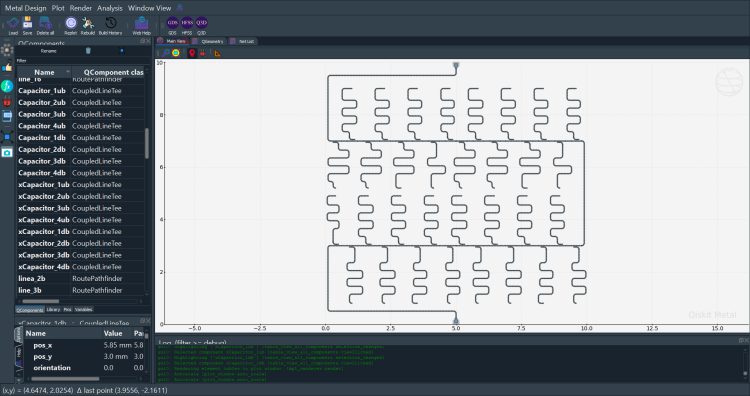

In [75]:
gui.autoscale()
gui.screenshot()


# GDS file

In [76]:
a_gds = design.renderers.gds
### import and place the cell names in the Fake_Junctions
a_gds.options['path_filename'] = 'Fake_Junctions.GDS'

In [77]:
### import and place the cell names in the Fake_Junctions
a_gds.options['path_filename'] = 'Fake_Junctions.GDS'

In [78]:
## for fillet the short segments, True means no fillet
a_gds.options['short_segments_to_not_fillet'] = 'False'

scale_fillet = 2.0
a_gds.options['check_short_segments_by_scaling_fillet'] = scale_fillet

In [79]:
# Restore a_gds options

a_gds.options.no_cheese['view_in_file']['main']={1: False}
a_gds.options.cheese['view_in_file']['main']={1: False}
a_gds.options['max_points'] = '8191'
a_gds.options['no_cheese']['buffer']='50um'
# We will shift the center of the chip to origin

design.chips.main.size['center_x'] = '5.0mm'
design.chips.main.size['center_y'] = '5.0mm'
design.rebuild()

### For demo, set max_points to 8191 and look at the GDS output.
a_gds.options['max_points'] = '8191'

# We next export it to GDS

design.renderers.gds.export_to_gds("32_array.gds")

03:54PM 02s WARNING [_import_junction_gds_file]: Not able to find file:"Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"C:\Users\Quantum Circuits IB\Documents\Kelvin\qiskit-metal\qmetal\simu\32_array".


1

In [30]:
#Many ways to view the QGeometry tables.
#If you want to view, uncomment below lines and and run it.

design.qgeometry.tables
# design.qgeometry.tables['path']
# design.qgeometry.tables['poly']

{'path':     component            name  \
 0           1       prime_cpw   
 1           1   prime_cpw_sub   
 2           1      second_cpw   
 3           1  second_cpw_sub   
 4           2       prime_cpw   
 ..        ...             ...   
 125        65             cut   
 126        66           trace   
 127        66             cut   
 128        67           trace   
 129        67             cut   
 
                                               geometry  layer  subtract  \
 0        LINESTRING (1.37500 9.00000, 1.62500 9.00000)      1     False   
 1        LINESTRING (1.37500 9.00000, 1.62500 9.00000)      1      True   
 2    LINESTRING (1.43750 8.94700, 1.56250 8.94700, ...      1     False   
 3    LINESTRING (1.42650 8.94700, 1.56250 8.94700, ...      1      True   
 4        LINESTRING (3.38800 9.00000, 3.61200 9.00000)      1     False   
 ..                                                 ...    ...       ...   
 125  LINESTRING (4.44400 1.15300, 4.44400 1.55300

In [31]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [32]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [33]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 01:38PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:38PM [load_ansys_project]: 	Opened Ansys App
INFO 01:38PM [load_ansys_project]: 	Opened Ansys Desktop v2018.0.0
INFO 01:38PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Quantum Circuits IB/Documents/Ansoft/
	Project:   Project14
INFO 01:38PM [connect_design]: No active design found (or error getting active design).
INFO 01:38PM [connect]: 	 Connected to project "Project14". No design detected


True

In [34]:
# Here we activate the design for a drivenmodal solution
hfss.activate_ansys_design("32pix_v1", 'drivenmodal')
setup_args = Dict(max_delta_s=0.01)
setup_args.name = 'Setup'
hfss.edit_drivenmodal_setup(setup_args)

01:38PM 08s WARNING [activate_ansys_design]: The design_name=32pix_v1 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 01:38PM [connect_design]: 	Opened active design
	Design:    32pix_v1 [Solution type: DrivenModal]
WARNING 01:38PM [connect_setup]: 	No design setup detected.
WARNING 01:38PM [connect_setup]: 	Creating driven modal default setup.
INFO 01:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
01:38PM 12s WARNING [edit_drivenmodal_setup]: In setup_args, key=max_delta_s, value=0.01 is not in pinfo.setup, the key/value pair from setup_args not added to Setup in Ansys.


In [35]:
# set buffer: espacio alrededor de la geometría que está siendo simulada
hfss.options['x_buffer_width_mm'] = 0.2
hfss.options['y_buffer_width_mm'] = 0.2

In [36]:
# clean the design if needed
hfss.clean_active_design()

In [37]:
# render the design
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)